In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from PIL import Image
from scipy import ndimage
from matplotlib import pyplot as plt
import numpy as np
import time
import cv2

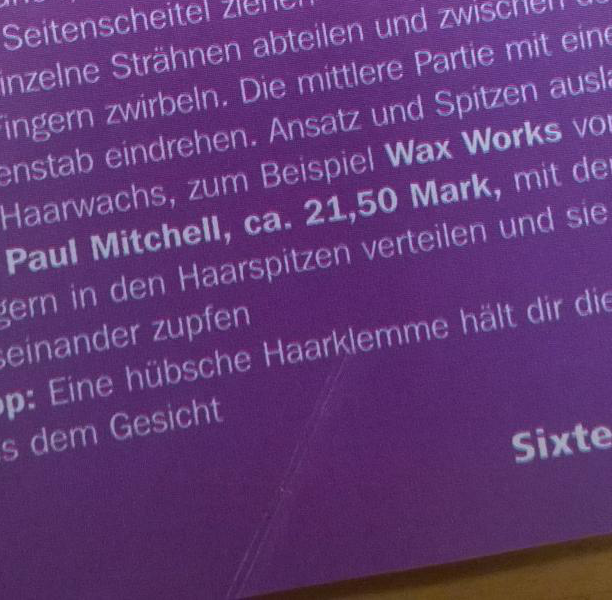

In [ ]:
img = np.array(Image.open('/content/gdrive/My Drive/ABBYY Homeworks/Задание 3/2.jpg'))
img_part = img[300:900, 500:1100]
Image.fromarray(img_part)

**Реализация быстрого преобразования Хафа**

Данный алгоритм применим для изображений с произвольной высотой и шириной, равной степени двух.

Функция calc_sums вызывается рекурсивно до глубины $O(\log n)$. Для каждой глубины рекурсии (для всех запусков функции на данной глубине) требуется $O(n^2)$ времени на перебор всех $x$, $shift$, и квадратичную по $n$ память для хранения результата. В итоге, теоретическая асимптотика по времени $O(n^2\log n)$, по памяти $O(n^2\log n)$

In [ ]:
def calc_sums(img, H, xmin, xmax):
    res = np.zeros([H, xmax-xmin])
    if xmax - xmin == 1:
        res[:, 0] = img[:, xmin]
    else:
        mid = (xmin + xmax) // 2
        ans1 = calc_sums(img, H, xmin, mid)
        ans2 = calc_sums(img, H, mid, xmax)
        for x in range(H):
            for shift in range(xmax-xmin):
                res[x, shift] = ans1[x, shift//2] + ans2[(x + shift//2 + shift%2) % H, shift//2]
    return res

def calc_FHT(img):
    H, W = img.shape[:2]
    
    return calc_sums(img, H, 0, W)

In [ ]:
def crop_W_to_p2(img):
    H, W = img.shape[:2]
    W_cropped = 2 ** int(np.log2(W))
    return img[:, :W_cropped, ...]

In [ ]:
#приводим изображение к одному каналу
def grayscale(x):
    R, G, B = x
    return 0.299 * R + 0.587 * G + 0.114 * B

def calc_intensity(img):
    return np.apply_along_axis(grayscale, -1, np.array(img, dtype=np.float32))

In [ ]:
def reverse_bits(num, n):
    if n == 0:
        return num
    b = '{:0{width}b}'.format(num, width=max(n, len(bin(num)) - 2))
    b = b[:-n] + b[-n:][::-1]
    return int(b, 2)

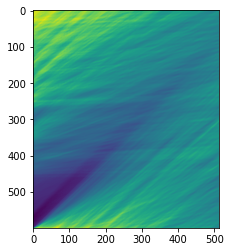

In [ ]:
cropped = crop_W_to_p2(np.array(img_part, dtype=np.float32))
intensities = calc_intensity(cropped)
fht = calc_FHT(intensities)

plt.imshow(fht)
plt.show()

In [ ]:
np.argmax(np.apply_along_axis(np.std, 0, fht)), np.max(np.apply_along_axis(np.std, 0, fht))

(0, 6149.083047742055)

**Время работы алгоритма**

In [ ]:
cropped = crop_W_to_p2(np.array(img, dtype=np.float32))
intensities = calc_intensity(cropped)

In [ ]:
intensities.shape

(900, 1024)

In [ ]:
Hs = [128, 256, 512, 800, 800]
Ws = [128, 256, 512, 512, 1024]

times = []
squares = []
for W, H in zip(Ws, Hs):
    input_ = intensities[:H, :W].copy()
    
    start_time = time.time()
    calc_FHT(input_)
    times.append((time.time() - start_time) * 1000)
    
    k = (H*W)/10**6
    squares.append(k)

In [ ]:
print("Время работы: ", times)
print("Площадь: ", squares)

Время работы:  [180.65190315246582, 436.2637996673584, 1870.1183795928955, 2868.690252304077, 7306.714057922363]
Площадь:  [0.016384, 0.065536, 0.262144, 0.4096, 0.8192]


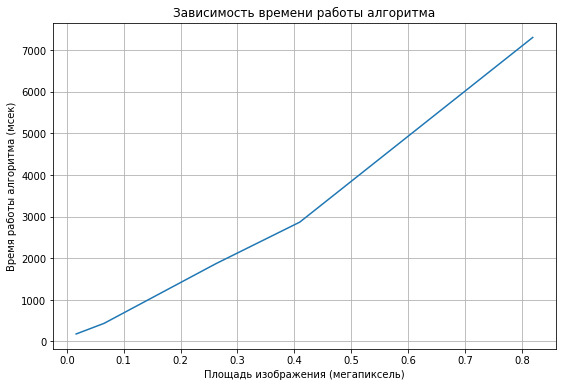

In [ ]:
plt.figure(figsize=(9,6))
plt.title("Зависимость времени работы алгоритма")

plt.xlabel("Площадь изображения (мегапиксель)")
plt.ylabel("Время работы алгоритма (мсек)")
plt.plot(squares, times)
plt.grid()

plt.show()

Так как увеличение площади имеет асимптотику $O(n^2)$, а реализация самого алгоритма имеет асимптотику по времени $O(n^2\log n)$, то итоговый график должен быть практически прямой линией, что и наблюдается на графике выше.

**Реализация поворота изображения**

In [ ]:
def clamp(x, smallest, largest): 
    return max(smallest, min(x, largest))

In [ ]:
def calc_neighbours(x, lim):
    x1, x2 = int(np.floor(x)), int(np.ceil(x))
    if x1 == x2:
        if x2 == lim - 1:
            x1 -= 1
        else:
            x2 += 1
    return x1, x2

In [ ]:
def inv_transform(x, y, beta, W, H, angle):
    # сжатие
    x, y = x * beta, y * beta
    # 1 параллельный перенос
    x, y = x - W * beta / 2, y - H * beta / 2 
    # поворот
    x, y = np.cos(angle) * x + np.sin(angle) * y, - np.sin(angle) * x + np.cos(angle) * y
    # 2 параллельный перенос
    x, y = x + W / 2, y + H / 2
    if x > W - 1 or x < 0 or y > H - 1 or y < 0:
        x = clamp(x, 0, W - 1)
        y = clamp(y, 0, H - 1)
    return x, y

def interpolate(y, x, src, strategy):
    H, W = src.shape[:2]
    if strategy == "nn":
        y_nn, x_nn = round(y), round(x)
        return src[y_nn, x_nn, :]
    elif strategy == "bl":
        x1, x2 = calc_neighbours(x, W)
        y1, y2 = calc_neighbours(y, H)
        src11 = src[y1, x1, ...]
        src12 = src[y2, x1, ...]
        src21 = src[y1, x2, ...]
        src22 = src[y2, x2, ...]
        f1 = src11 + (x - x1) * (src21 - src11)
        f2 = src12 + (x - x1) * (src22 - src12)
        return f1 + (y - y1) * (f2 - f1)
        
def rotate(img, angle, strategy="nn"):
    H, W = img.shape[:2]
    # коэффициент растяжения
    beta = min(W / (W * np.cos(angle) + H * np.abs(np.sin(angle))), H / (W * np.abs(np.sin(angle)) + H * np.cos(angle)))
    result = np.zeros_like(img)
    
    for i in range(W):
        for j in range(H):
            x, y = inv_transform(i, j, beta, W, H, angle)
            result[j][i] = interpolate(y, x, img, strategy)
    return result

Bilinear


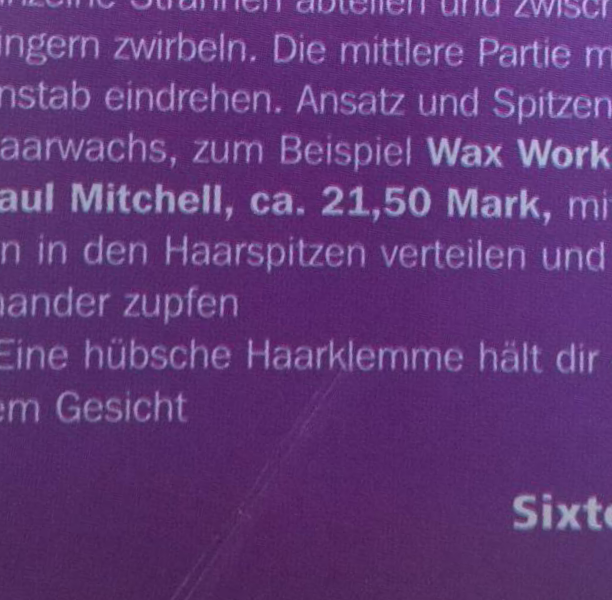

In [ ]:
rotated = rotate(np.array(img_part, dtype=np.float32), np.pi / 2 + np.pi / 18, strategy = "bl")
print("Bilinear")
Image.fromarray(np.array(rotated, dtype=np.uint8))

Nearest neighbor


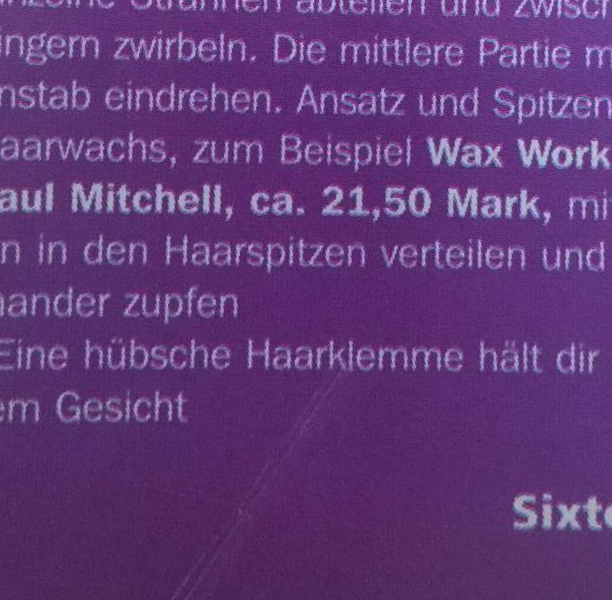

In [ ]:
rotated = rotate(np.array(img_part, dtype=np.float32), np.pi / 2 + np.pi / 18)
print("Nearest neighbor")
Image.fromarray(np.array(rotated, dtype=np.uint8))

Считая, что исходное изображение повернуто на угол меньше чем 45 градусов, вычислим с помощью преобразования Хафа угол на который необходимо повернуть изображение и совершим поворот

In [ ]:
def autorotation(img, interpolate_strat="bl"):
    # обрезаем по ширине
    cropped = crop_W_to_p2(np.array(img, dtype=np.float32))
    # оставляем один канал
    intensities = calc_intensity(cropped)
    intensities_flip = np.flip(intensities, axis=1)
    # применяем фильтр Гаусса
    gauss = cv2.GaussianBlur(intensities, (3, 3), 0)
    gauss_flip = cv2.GaussianBlur(intensities_flip, (3, 3), 0)
    
    # получаем модули градиента
    grad_x = cv2.Sobel(gauss, 3, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gauss, 3, 0, 1, ksize=3)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    # получаем модули градиента для симметрично отраженного изображения
    grad_x_flip = cv2.Sobel(gauss_flip, 3, 1, 0, ksize=3)
    grad_y_flip = cv2.Sobel(gauss_flip, 3, 0, 1, ksize=3)
    abs_grad_x_flip = cv2.convertScaleAbs(grad_x_flip)
    abs_grad_y_flip = cv2.convertScaleAbs(grad_y_flip)
    grad_flip = cv2.addWeighted(abs_grad_x_flip, 0.5, abs_grad_y_flip, 0.5, 0)
    
    # считаем быстрое преобразование Хафа
    grad = calc_FHT(grad)
    grad_flip = calc_FHT(grad_flip)
    
    # Вычисляем направление с максимальной дисперсией преобразования Хафа
    var = np.apply_along_axis(np.var, 0, grad)
    var_flip = np.apply_along_axis(np.var, 0, grad_flip)
    
    shift = np.argmax(var) # reverse_bits(np.argmax(var), round(np.log2(grad.shape[1])))
    shift_flip = np.argmax(var_flip) # reverse_bits(np.argmax(var_flip), round(np.log2(grad_flip.shape[1])))
    
    if np.max(var) > np.max(var_flip):
        alpha = np.arctan(shift / grad.shape[1])
    else:
        alpha = -np.arctan(shift_flip / grad_flip.shape[1])
  
    rotated = rotate(np.array(img, dtype=np.float32), -alpha, strategy = interpolate_strat)
    return rotated

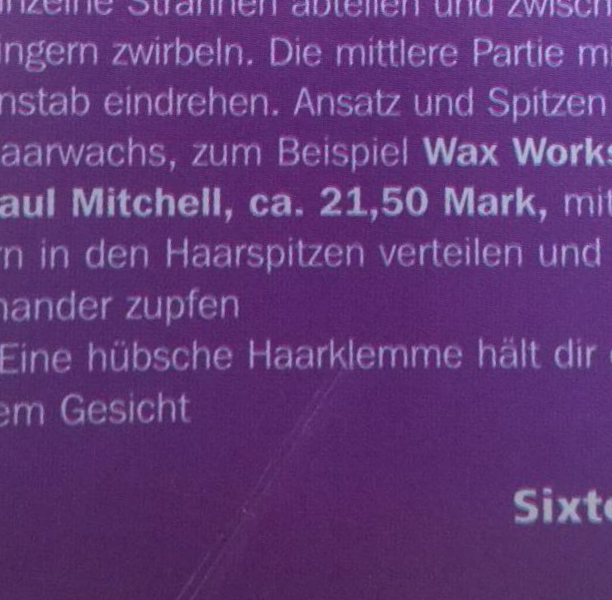

In [ ]:
Image.fromarray(np.array(autorotation(img_part), dtype=np.uint8))

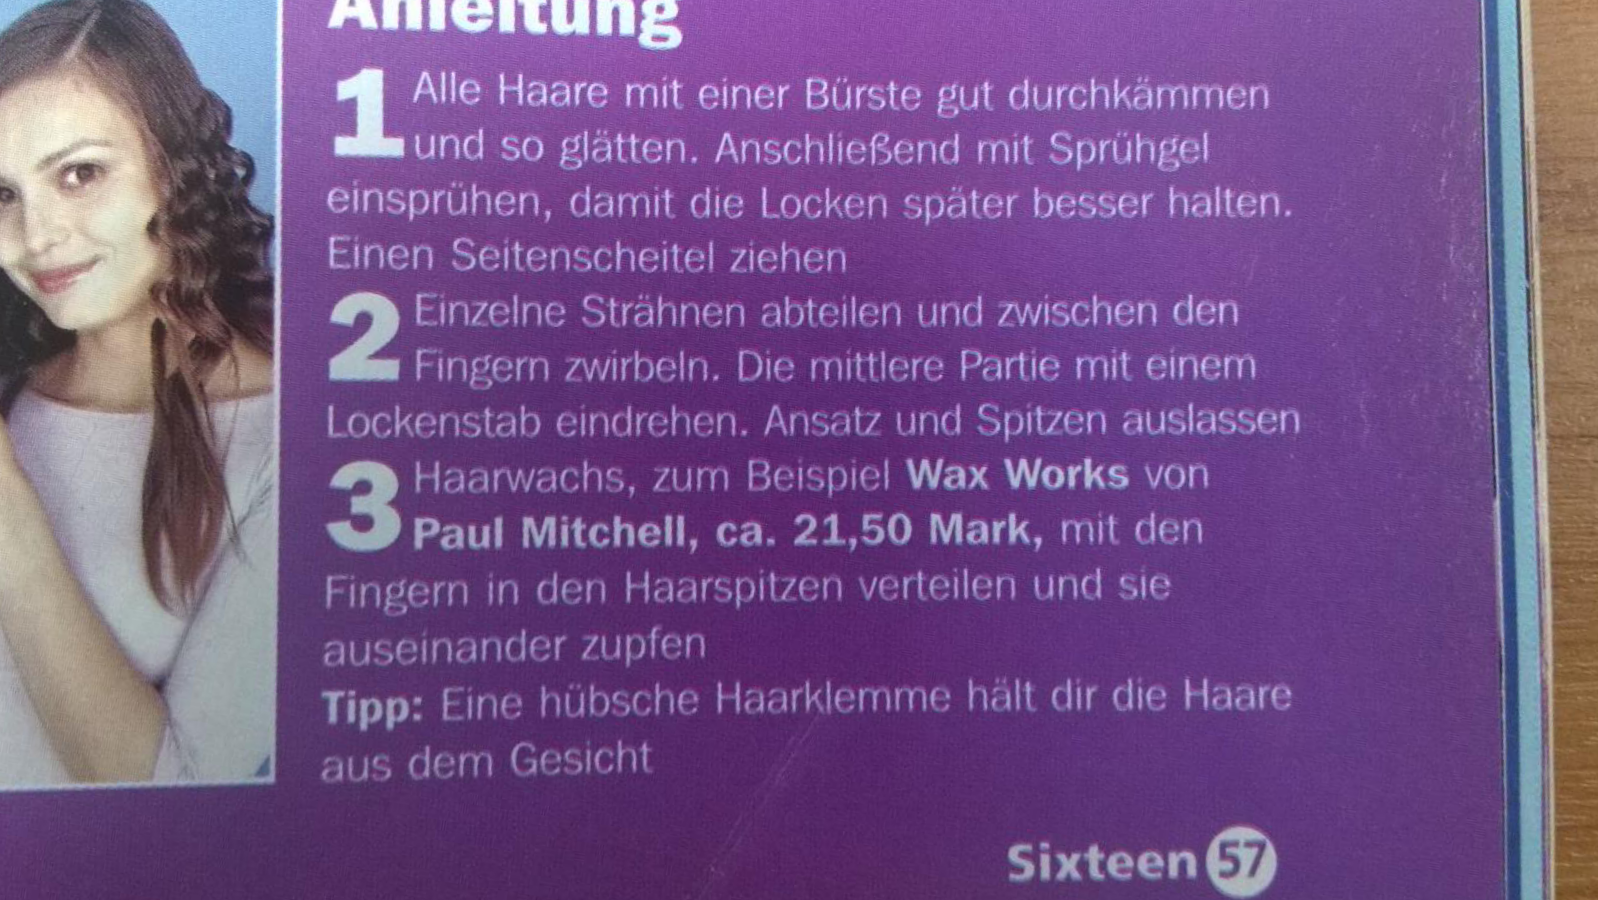

In [ ]:
Image.fromarray(np.array(autorotation(img), dtype=np.uint8))

**Сохраним повернутые изображения**

In [ ]:
for i in range(1, 11):
    img = np.array(Image.open('/content/gdrive/My Drive/ABBYY Homeworks/Задание 3/' + str(i) + '.jpg'), dtype=np.float32)
    Image.fromarray(np.array(autorotation(img), dtype=np.uint8)).save(str(i) + '_rotated.jpg')